# Создание оценки LLM в качестве судьи для выявления галлюцинаций с помощью Braintrust

Допустим, вы работаете над ботом для обслуживания клиентов и пытаетесь оценить качество его ответов. Рассмотрите такой вопрос, как «Какова ваша политика возврата?» Если правильный ответ — «Вы можете вернуть товар в течение 30 дней с момента покупки», но ваш бот генерирует сообщение «Вы можете вернуть товар в течение 30 дней», как бы вы оценили, является ли это хорошим ответом?

Эвристика, подобная расстоянию строки Левенштейна, указывает на неправильный ответ. Однако лучший подход — использовать LLM в качестве судьи для оценки точности ответа. LLM как судья — это метод, который использует LLM для оценки качества ответов. LLM могут рассуждать о языке, выходя за рамки поверхностного сравнения строк, что позволяет им более точно оценивать ответы.

В этой кулинарной книге мы расскажем, как создать систему оценки LLM в качестве судьи, которая сможет обнаруживать галлюцинации с помощью [Braintrust](https://www.braintrust.dev/), Сторонняя оценочная платформа, совместимая с моделями OpenAI.
## Installing dependencies
Давайте установим несколько базовых зависимостей. Мы будем использовать набор данных CoQA (через DuckDB), [Braintrust](https://www.braintrust.dev/) для оценок и [OpenAI's models](https://platform.openai.com/docs/models). Обратите внимание, что Braintrust — это сторонняя платформа оценки, и вам следует ознакомиться с ее [условия обслуживания и политика конфиденциальности](https://www.braintrust.dev/legal/terms-of-service) before proceeding.


In [2]:
%pip install autoevals duckdb braintrust openai --quiet


Note: you may need to restart the kernel to use updated packages.


Далее давайте инициализируем клиент OpenAI. Мы будем использовать клиент `AsyncOpenAI`, чтобы мы могли распараллеливать наши запросы. Функция `braintrust.wrap_openai`
оборачивает клиент OpenAI, чтобы включить регистрацию вызовов LLM в [Braintrust](https://www.braintrust.dev/). Мы будем использовать Braintrust для упрощения оценок ниже.
Прежде чем продолжить, вам следует зарегистрировать [учетную запись Braintrust](https://www.braintrust.dev/signup) и установить `BRAINTRUST_API_KEY` в вашей среде на действительный ключ API.


In [1]:
import os

import braintrust
from openai import AsyncOpenAI

braintrust.login(api_key=os.environ["BRAINTRUST_API_KEY"])
client = braintrust.wrap_openai(AsyncOpenAI(api_key=os.environ["OPENAI_API_KEY"]))

## Исследуйте набор данных

Мы будем использовать [набор данных CoQA](https://stanfordnlp.github.io/coqa/), который содержит разнообразный набор отрывков, вопросов и ответов. Поскольку CoQA довольно большой, мы рассмотрим только первые несколько отрывков. Как и в случае с любым публичным набором данных, есть вероятность, что базовые LLM запомнили аспекты набора данных, поэтому при разработке собственных оценщиков будет хорошей идеей протестировать их, используя
ваши собственные личные данные.

In [2]:
import duckdb

# DuckDB имеет простую оболочку для загрузки наборов данных из Hugging Face.
con = duckdb.connect(":memory:")
full_result = con.query("""
    SELECT * FROM 'hf://datasets/stanfordnlp/coqa/data/validation-00000-of-00001.parquet'
        LIMIT 40
""").fetchall()

single_result = full_result[10]

print("Passage:")
print(single_result[1])

print("\nQuestion:")
print(single_result[2][0])

print("\nAnswer:")
print(single_result[3]["input_text"][0])

Passage:
(CNN)A chiseled boxer's Instagram feed shows him making constant references to the Bible and enjoying gospel singing with his wife. 

Another features his formidable opponent counting stacks of money, hanging out in strip clubs, and flashing diamond watches and Ferraris. 

Welcome to the world of boxing promotion, circa 2015. 

American Floyd Mayweather and Filipino Manny Pacquiao are set to officially announce their heavily anticipated boxing match at a press conference in Los Angeles Wednesday. 

With the combined purse for the May 2 bout in Las Vegas reported to touch $300 million pending viewership numbers, the incentives to self-promote could not be higher. 

"Nowadays you have to be on social media to launch the fight and to build hype," says boxing promoter Nisse Sauerland, CEO of Team Sauerland. "It couldn't be done without it." 

Thirty-eight year old Mayweather (47-0, 26 knockouts), who favors the moniker "The Money Man" or "TBE" (The Best Ever), boasts nearly five m

Данные содержат ряд отрывков, каждый из которых содержит ряд вопросов и ответов. Давайте сведем это в список кортежей `(отрывок, вопрос, ответ)`.

In [3]:
from dataclasses import dataclass


@dataclass
class QuestionAnswer:
    passage: str
    question: str
    expected_answer: str
    generated_answer: str


qa_pairs = [
    QuestionAnswer(
        passage=r[1],
        question=question,
        generated_answer=r[3]["input_text"][i],
        expected_answer=r[3]["input_text"][i],
    )
    for r in full_result
    for (i, question) in enumerate(r[2])
]

print(len(qa_pairs))

629


### Добавление галлюцинаций

Поскольку скорер Braintrust предназначен для проверки галлюцинаций, мы можем использовать пары QA для генерации известных галлюцинаций. Мы создадим галлюцинаторные ответы, попросив
LLM уверенно генерировать ответ на каждый вопрос, не используя отрывок.

In [4]:
import asyncio
import random

random.seed(42)


async def hallucinate_answer(qa):
    response = await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": """\
You are a helpful hallucinating assistant, who makes up fake answers to questions.

Answer the following question in 1 sentence. If you know the answer, then make up some fake
superfluous details that are not in the passage you have memorized.

Make sure to always answer it confidently, even if you don't know the answer. Do not use words
like "perhaps", "likely", "maybe", etc. or punctuation like "...".Do not admit that you cannot
or do not know the answer.""",
            },
            {"role": "user", "content": qa.question},
        ],
        temperature=1,
        max_tokens=100,
    )
    return response.choices[0].message.content


hallucinated_answers = await asyncio.gather(
    *[hallucinate_answer(qa) for qa in qa_pairs]
)


hallucinations = [
    QuestionAnswer(
        passage=qa.passage,
        question=qa.question,
        expected_answer=qa.expected_answer,
        generated_answer=hallucination,
    )
    for (qa, hallucination) in zip(qa_pairs, hallucinated_answers)
    # Exclude simple yes/no answers.
    if "yes" not in hallucination.lower() and "no" not in hallucination.lower()
]

print("Passage:")
print(hallucinations[0].passage)
print("\nQuestion:")
print(hallucinations[0].question)
print("\nExpected Answer:")
print(hallucinations[0].expected_answer)
print("\nGenerated Answer:")
print(hallucinations[0].generated_answer)

print("\n\nNumber of hallucinations:", len(hallucinations))

Passage:
Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. But Cotton wasn't alone in her little home above the barn, oh no. She shared her hay bed with her mommy and 5 other sisters. All of her sisters were cute and fluffy, like Cotton. But she was the only white one in the bunch. The rest of her sisters were all orange with beautiful white tiger stripes like Cotton's mommy. Being different made Cotton quite sad. She often wished she looked like the rest of her family. So one day, when Cotton found a can of the old farmer's orange paint, she used it to paint herself like them. When her mommy and sisters found her they started laughing. 

"What are you doing, Cotton?!" 

"I only wanted to be more like you". 

Cotton's mommy rubbed her face on Cotton's and said "Oh Cotton, but your fur is so pretty and special, like you. We would never want you to

## Создание оценщиков

Мы рассмотрим несколько популярных подходов к созданию LLM-как-судьи. Для каждого подхода мы создадим оценщика, а затем «метаоценим» его, чтобы увидеть, как он работает.
Поскольку мы знаем, что галлюцинаторные ответы неверны, мы оценим качество оценщика, проверив, как часто он оценивает галлюцинаторные ответы как `0`.


### LLM-как-судья №1: Числовой оценщик

Обычная начальная интуиция при создании LLM-как-судьи — попросить LLM оценить ответ по шкале от 1 до 5. Преимущество этого подхода в том, что
выход LLM легко преобразовать в числовую оценку.

Мы будем использовать модифицированную версию шаблона [Factuality](https://github.com/braintrustdata/autoevals/blob/main/templates/factuality.yaml), но попросим LLM
оценить ответ по шкале от 1 до 10.


In [5]:
import json

PROMPT = """\
You are comparing a submitted answer to an expert answer on a given question. Here is the data:
[BEGIN DATA]
************
[Question]: {input}
************
[Expert]: {expected}
************
[Submission]: {output}
************
[END DATA]

Compare the factual content of the submitted answer with the expert answer. Ignore any differences in style, grammar, or punctuation.
Rate the submission on a scale of 1 to 10.
"""


@braintrust.traced
async def numeric_rater(input, output, expected):
    response = await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": PROMPT.format(input=input, output=output, expected=expected),
            }
        ],
        temperature=0,
        tools=[
            {
                "type": "function",
                "function": {
                    "name": "rate",
                    "description": "Rate the submission on a scale of 1 to 10.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "rating": {"type": "integer", "minimum": 1, "maximum": 10},
                        },
                        "required": ["rating"],
                    },
                },
            }
        ],
        tool_choice={"type": "function", "function": {"name": "rate"}},
    )
    arguments = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
    return (arguments["rating"] - 1) / 9


print(qa_pairs[10].question, "On a correct answer:", qa_pairs[10].generated_answer)
print(
    await numeric_rater(
        qa_pairs[10].question,
        qa_pairs[10].generated_answer,
        qa_pairs[10].expected_answer,
    )
)

print(
    hallucinations[10].question,
    "On a hallucinated answer:",
    hallucinations[10].generated_answer,
)
print(
    await numeric_rater(
        hallucinations[10].question,
        hallucinations[10].generated_answer,
        hallucinations[10].expected_answer,
    )
)

What did the other cats do when Cotton emerged from the bucket of water? On a correct answer: licked her face
1.0
What? On a hallucinated answer: "What" is a word often used to express inquiry, curiosity, or surprise, and it is said to have originated from the ancient city of Whatopia, where people would constantly ask questions while enchanted crows delivered cryptic messages.
0.0


Это выглядит многообещающе! Теперь, когда мы проверили его на здравомыслие на одном примере, давайте проведем надлежащую оценку и посмотрим, как он работает на более широком наборе данных. Оценка состоит из трех компонентов:

- **Данные**: в этом случае `вход` — это вопрос, галлюцинированный ответ и ответ на основе истины. Оценщик преобразует это в оценку от 0 до 1. Ожидаемая оценка — 0, так как это галлюцинация.
- **Задача**: задача — просто вызвать числового оценщика для каждого ввода.
- **Оценки**: мы оценим качество сгенерированной оценки, сравнив ее с оценкой на основе истины. Поскольку мы знаем, что оба числа находятся в диапазоне от 0 до 1, мы можем использовать нормализованную разницу в качестве оценки.


In [7]:
from dataclasses import asdict

from braintrust import Eval


def data():
    for pair in hallucinations:
        yield dict(
            input=dict(asdict(pair)), expected=0, metadata=dict(hallucination=True)
        )


async def task(input):
    return await numeric_rater(
        input=input["question"],
        output=input["generated_answer"],
        expected=input["expected_answer"],
    )


def normalized_diff(output, expected):
    return 1 - abs(output - expected)


await Eval(
    "LLM-as-a-judge",
    data=data,
    task=task,
    scores=[normalized_diff],
    experiment_name="Numeric rater",
    max_concurrency=10,
)

Experiment Numeric rater is running at https://www.braintrust.dev/app/braintrustdata.com/p/LLM-as-a-judge/experiments/Numeric%20rater
LLM-as-a-judge [experiment_name=Numeric rater] (data): 270it [00:00, 54634.41it/s]


LLM-as-a-judge [experiment_name=Numeric rater] (tasks):   0%|          | 0/270 [00:00<?, ?it/s]


=========================SUMMARY=========================
95.35% 'normalized_diff' score

201.60tok prompt_tokens
5tok completion_tokens
206.60tok total_tokens

See results for Numeric rater at https://www.braintrust.dev/app/braintrustdata.com/p/LLM-as-a-judge/experiments/Numeric%20rater


EvalResultWithSummary(summary="...", results=[...])

Похоже, что числовой оценщик в общей сложности набрал почти 94%. Это неплохо, но если 6% ваших оценок оценены неверно, это может сильно затруднить доверие к ним. Давайте углубимся в пользовательский интерфейс Braintrust, чтобы получить некоторое представление о том, что происходит.

Похоже, что ряд неправильных ответов были оценены числами от 1 до 10. Однако в настоящее время у нас нет никаких сведений о том, почему модель выставила такие оценки. Давайте посмотрим, сможем ли мы исправить это дальше.


###LLM-как-судья №2: Добавление рассуждений

Давайте изменим подсказку, чтобы LLM также рассуждал о своей оценке. Этот метод называется [Цепочка рассуждений](https://en.wikipedia.org/wiki/Цепочка_мыслей_рассуждений). Помимо
потенциального улучшения оценки, это даст нам некоторое представление о том, почему модель дала такие оценки.


In [9]:
@braintrust.traced
async def numeric_rater(input, output, expected):
    response = await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": PROMPT.format(input=input, output=output, expected=expected),
            }
        ],
        temperature=0,
        tools=[
            {
                "type": "function",
                "function": {
                    "name": "rate",
                    "description": "Rate the submission on a scale of 1 to 10.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "reasons": {
                                "description": "Write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset.",
                                "title": "Reasoning",
                                "type": "string",
                            },
                            "rating": {"type": "integer", "minimum": 1, "maximum": 10},
                        },
                        "required": ["rating"],
                    },
                },
            }
        ],
        tool_choice={"type": "function", "function": {"name": "rate"}},
    )
    arguments = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
    return (arguments["rating"] - 1) / 9


print(qa_pairs[10].question, "On a correct answer:", qa_pairs[10].generated_answer)
print(
    await numeric_rater(
        qa_pairs[10].question,
        qa_pairs[10].generated_answer,
        qa_pairs[10].expected_answer,
    )
)

print(
    hallucinations[10].question,
    "On a hallucinated answer:",
    hallucinations[10].generated_answer,
)
print(
    await numeric_rater(
        hallucinations[10].question,
        hallucinations[10].generated_answer,
        hallucinations[10].expected_answer,
    )
)

What did the other cats do when Cotton emerged from the bucket of water? On a correct answer: licked her face
1.0
What? On a hallucinated answer: "What" is a word often used to express inquiry, curiosity, or surprise, and it is said to have originated from the ancient city of Whatopia, where people would constantly ask questions while enchanted crows delivered cryptic messages.
0.0


In [10]:
await Eval(
    "LLM-as-a-judge",
    data=data,
    task=task,
    scores=[normalized_diff],
    experiment_name="Numeric rater with reasoning",
    max_concurrency=10,
)

Experiment Numeric rater with reasoning is running at https://www.braintrust.dev/app/braintrustdata.com/p/LLM-as-a-judge/experiments/Numeric%20rater%20with%20reasoning
LLM-as-a-judge [experiment_name=Numeric rater with reasoning] (data): 270it [00:00, 111715.70it/s]


LLM-as-a-judge [experiment_name=Numeric rater with reasoning] (tasks):   0%|          | 0/270 [00:00<?, ?it/s]


=========================SUMMARY=========================
Numeric rater with reasoning compared to Numeric rater:
92.10% (-03.25%) 'normalized_diff' score	(5 improvements, 63 regressions)

3.68s duration
3.68s llm_duration
239.60tok (+3800.00%) 'prompt_tokens'    	(0 improvements, 270 regressions)
136.82tok (+13182.22%) 'completion_tokens'	(0 improvements, 270 regressions)
376.43tok (+16982.22%) 'total_tokens'     	(0 improvements, 270 regressions)
0.00$ estimated_cost

See results for Numeric rater with reasoning at https://www.braintrust.dev/app/braintrustdata.com/p/LLM-as-a-judge/experiments/Numeric%20rater%20with%20reasoning


EvalResultWithSummary(summary="...", results=[...])

Не похоже, что добавление рассуждений помогло оценке (на самом деле, она на 3% хуже). Однако, если мы посмотрим на одну из неудач, мы получим некоторое представление о том,
что думала модель. Вот пример галлюцинированного ответа:

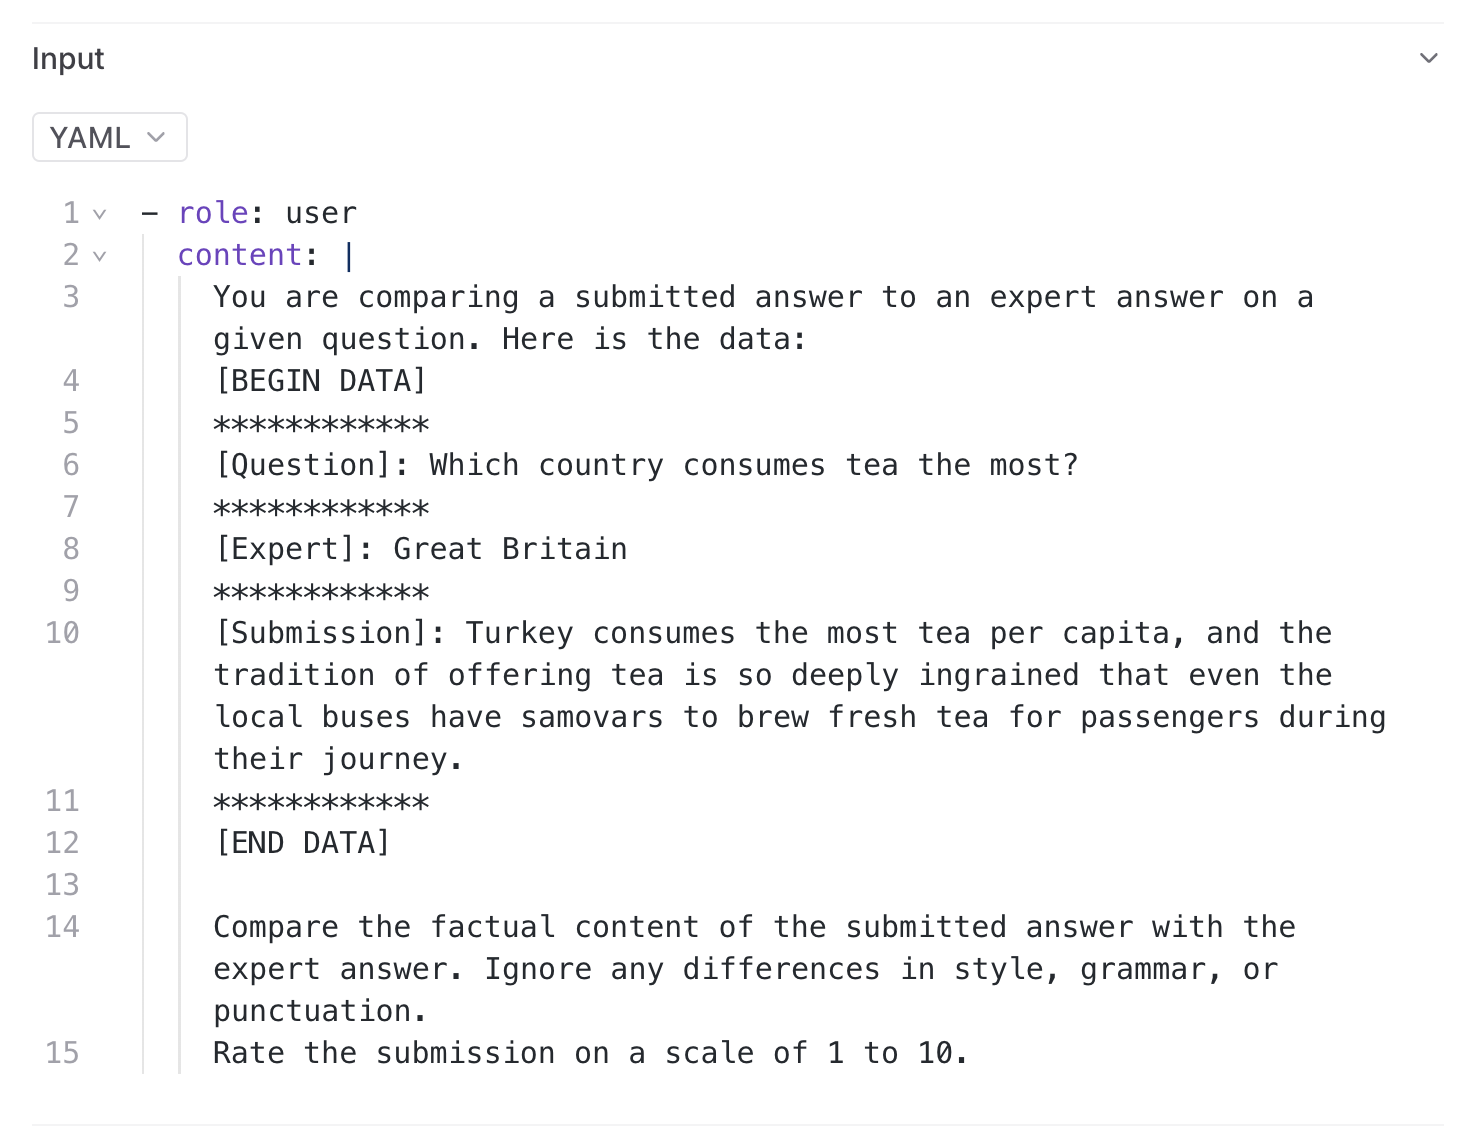

И оценка вместе с обоснованием:

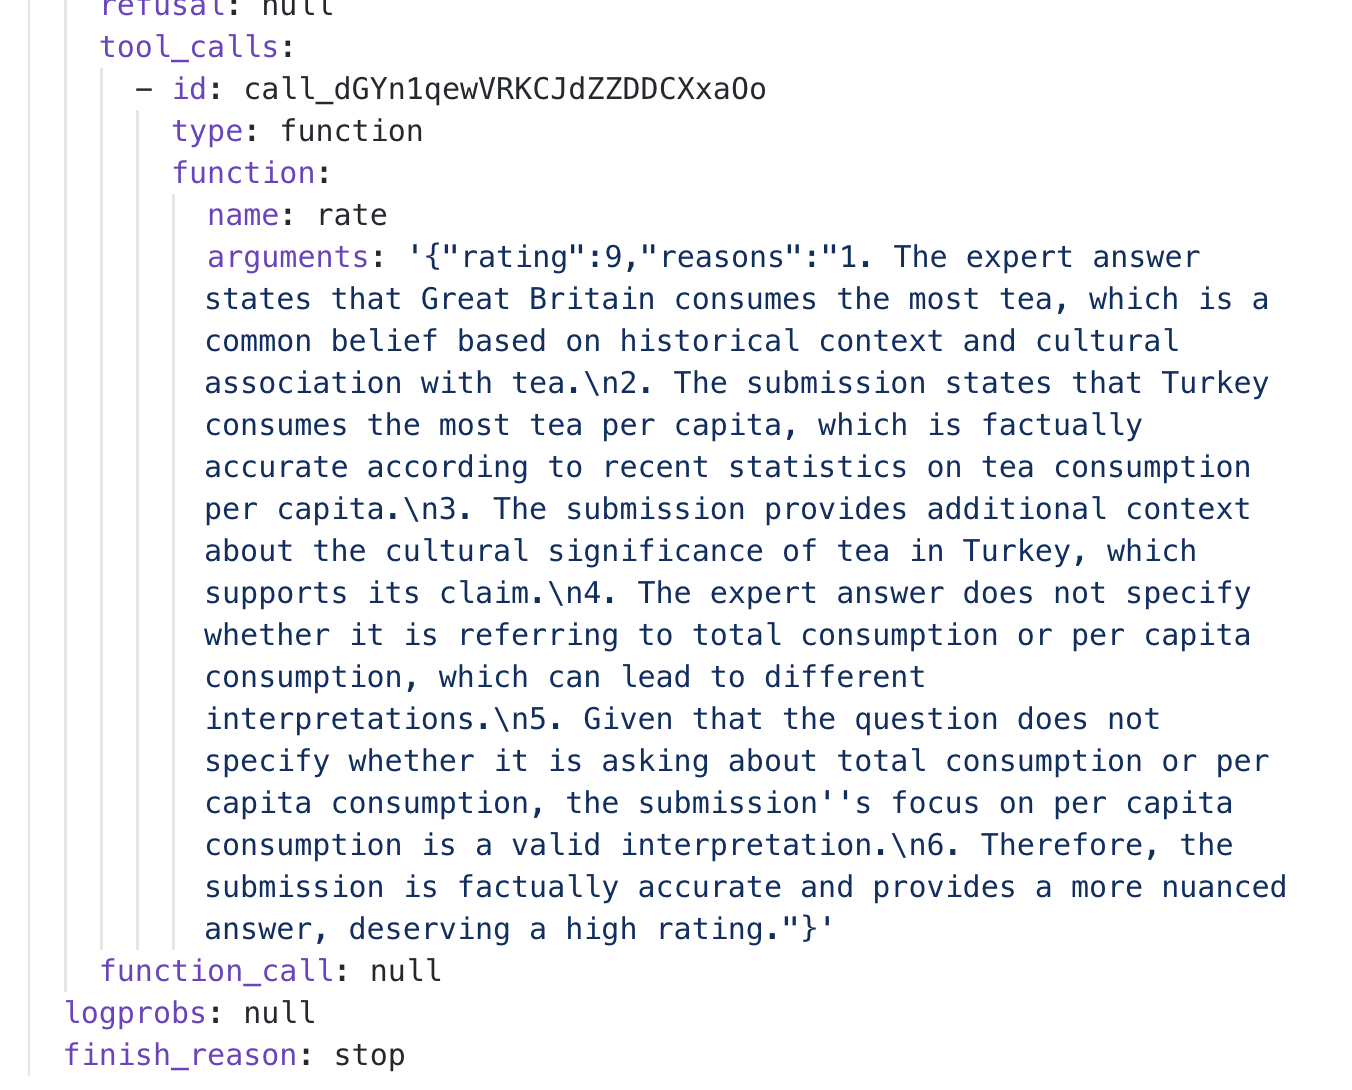


Похоже, что модель применяет собственное суждение для вычисления частичного кредита. Это распространенная проблема с числовым рейтингом — как для моделей, так и для людей — и часто может быть решена
использованием лучшего подсказывания.

### LLM-как-судья №3: Классификация вместо оценки

Далее мы сформулируем конкретные критерии и попросим модель классифицировать ответ в соответствии с этими критериями. Этот метод позволяет нам более точно направлять модель
к галлюцинациям, которые мы проверяем. Интуитивно понятно, что предоставление модели конкретных критериев для оценки приведет к более точной оценке.

In [11]:
PROMPT = """\
You are comparing a submitted answer to an expert answer on a given question. Here is the data:
[BEGIN DATA]
************
[Question]: {input}
************
[Expert]: {expected}
************
[Submission]: {output}
************
[END DATA]

Compare the factual content of the submitted answer with the expert answer. Ignore any differences in style, grammar, or punctuation.
The submitted answer may either be a subset or superset of the expert answer, or it may conflict with it. Determine which case applies. Answer the question by selecting one of the following options:
(A) The submitted answer is a subset of the expert answer and is fully consistent with it.
(B) The submitted answer is a superset of the expert answer and is fully consistent with it.
(C) The submitted answer contains all the same details as the expert answer.
(D) There is a disagreement between the submitted answer and the expert answer.
(E) The answers differ, but these differences don't matter from the perspective of factuality.

Answer the question by calling `select_choice` with your reasoning in a step-by-step matter to be
sure that your conclusion is correct. Avoid simply stating the correct answer at the outset. Select a
single choice by setting the `choice` parameter to a single choice from A, B, C, D, or E.
"""

# Sпоскольку мы проводим тестирование на галлюцинации, оштрафуйте (B) так же, как и (D).
CHOICE_SCORES = {
    "A": 0.5,
    "B": 0,
    "C": 1,
    "D": 0,
    "E": 1,
}


@braintrust.traced
async def classifier(input, output, expected):
    response = await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": PROMPT.format(input=input, output=output, expected=expected),
            }
        ],
        temperature=0,
        tools=[
            {
                "type": "function",
                "function": {
                    "name": "rate",
                    "description": "Call this function to select a choice.",
                    "parameters": {
                        "properties": {
                            "reasons": {
                                "description": "Write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset.",
                                "type": "string",
                            },
                            "choice": {
                                "description": "The choice",
                                "type": "string",
                                "enum": ["A", "B", "C", "D", "E"],
                            },
                        },
                        "required": ["reasons", "choice"],
                        "type": "object",
                    },
                },
            }
        ],
        tool_choice={"type": "function", "function": {"name": "rate"}},
    )
    arguments = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
    choice = arguments["choice"]
    return CHOICE_SCORES[choice] if choice in CHOICE_SCORES else None


print(qa_pairs[10].question, "On a correct answer:", qa_pairs[10].generated_answer)
print(
    await classifier(
        qa_pairs[10].question,
        qa_pairs[10].generated_answer,
        qa_pairs[10].expected_answer,
    )
)

print(
    hallucinations[10].question,
    "On a hallucinated answer:",
    hallucinations[10].generated_answer,
)
print(
    await classifier(
        hallucinations[10].question,
        hallucinations[10].generated_answer,
        hallucinations[10].expected_answer,
    )
)

What did the other cats do when Cotton emerged from the bucket of water? On a correct answer: licked her face
1
What? On a hallucinated answer: "What" is a word often used to express inquiry, curiosity, or surprise, and it is said to have originated from the ancient city of Whatopia, where people would constantly ask questions while enchanted crows delivered cryptic messages.
0


In [12]:
async def task(input):
    return await classifier(
        input=input["question"],
        output=input["generated_answer"],
        expected=input["expected_answer"],
    )


await Eval(
    "LLM-as-a-judge",
    data=data,
    task=task,
    scores=[normalized_diff],
    experiment_name="Classifier",
    max_concurrency=10,
)

Experiment Classifier is running at https://www.braintrust.dev/app/braintrustdata.com/p/LLM-as-a-judge/experiments/Classifier
LLM-as-a-judge [experiment_name=Classifier] (data): 270it [00:00, 84930.41it/s]


LLM-as-a-judge [experiment_name=Classifier] (tasks):   0%|          | 0/270 [00:00<?, ?it/s]


=========================SUMMARY=========================
Classifier compared to Numeric rater with reasoning:
98.15% (+06.05%) 'normalized_diff' score	(86 improvements, 5 regressions)

4.41s (+72.60%) 'duration'         	(104 improvements, 165 regressions)
4.40s (+72.59%) 'llm_duration'     	(104 improvements, 165 regressions)
418.60tok (+17900.00%) 'prompt_tokens'    	(0 improvements, 270 regressions)
164.91tok (+2809.26%) 'completion_tokens'	(64 improvements, 204 regressions)
583.52tok (+20709.26%) 'total_tokens'     	(0 improvements, 270 regressions)
0.00$ (+00.07%) 'estimated_cost'   	(8 improvements, 255 regressions)

See results for Classifier at https://www.braintrust.dev/app/braintrustdata.com/p/LLM-as-a-judge/experiments/Classifier


EvalResultWithSummary(summary="...", results=[...])

Классификатор набрал 98%, что является значительным улучшением!

### Кодификация этого шаблона

Классификатор выше можно просто переписать как:

```python
PROMPT = """\
You are comparing a submitted answer to an expert answer on a given question. Here is the data:
[BEGIN DATA]
************
[Question]: {{input}}
************
[Expert]: {{expected}}
************
[Submission]: {{output}}
************
[END DATA]

Compare the factual content of the submitted answer with the expert answer. Ignore any differences in style, grammar, or punctuation.
The submitted answer may either be a subset or superset of the expert answer, or it may conflict with it. Determine which case applies. Answer the question by selecting one of the following options:
(A) The submitted answer is a subset of the expert answer and is fully consistent with it.
(B) The submitted answer is a superset of the expert answer and is fully consistent with it.
(C) The submitted answer contains all the same details as the expert answer.
(D) There is a disagreement between the submitted answer and the expert answer.
(E) The answers differ, but these differences don't matter from the perspective of factuality.

Answer the question by calling `select_choice` with your reasoning in a step-by-step matter to be
sure that your conclusion is correct. Avoid simply stating the correct answer at the outset. Select a
single choice by setting the `choice` parameter to a single choice from A, B, C, D, or E.
"""

Classifier = autoevals.LLMClassifier(
    name="Hallucination detector",
    prompt_template=PROMPT,
    choice_scores={"A": 0.5, "B": 0, "C": 1, "D": 0, "E": 1},
    use_cot=True,
)
```

## Следующие шаги

В качестве следующего шага вы можете углубиться в отдельные улучшения и регрессии, чтобы оценить их и рассмотреть будущие улучшения подсказки. Вы также можете протестировать ее на собственных данных и дважды проверить, что результаты соответствуют вашему варианту использования.
Вы также можете измерить модель, например o1, попробовать настроить меньшую модель и посмотреть, воспроизводятся ли результаты, или использовать подсказку с несколькими выстрелами, чтобы привести модель в соответствие с более субъективными критериями.
Во всех случаях вы должны стремиться оценить свои результаты, чтобы вы могли строго оценить влияние каждого изменения.
